In [ ]:
train = True

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Mount Google Drive and set data paths.
import os
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ML4H - Project 2

## Task 1

In [ ]:
# Gloabal variables
data_path = "/content/gdrive/My Drive/ETH/MLH/Project2/data/PubMed_200k_RCT/"
model_path = "/content/gdrive/My Drive/ETH/MLH/Project2/model/"

seed = 50

In [ ]:
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras import models, optimizers, losses, metrics
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_df = pd.read_parquet(data_path + 'pre_processed_train.gzip')
test_df = pd.read_parquet(data_path + 'pre_processed_test.gzip')
dev_df = pd.read_parquet(data_path + 'pre_processed_dev.gzip')

In [ ]:
train_df.head(5)

,Label,Words
0,BACKGROUND,"[emerg, hiv, chronic, condit, mean, peopl, liv..."
1,BACKGROUND,"[paper, describ, design, evalu, posit, outlook..."
2,METHODS,"[studi, design, randomis, control, trial, men,..."
3,METHODS,"[intervent, group, particip, onlin, group, pro..."
4,METHODS,"[program, base, self, efficaci, theori, use, s..."


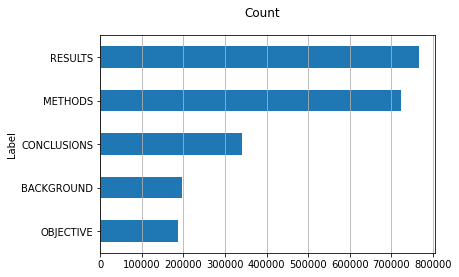

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Count", fontsize=12)
train_df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
train_lab = train_df['Label']
train_words = train_df['Words']

test_lab = test_df['Label']
test_words = test_df['Words']

dev_lab = dev_df['Label']
dev_words = dev_df['Words']

In [ ]:
train_lab[0]

'BACKGROUND'

In [ ]:
train_words[0]

array(['emerg', 'hiv', 'chronic', 'condit', 'mean', 'peopl', 'live',
       'hiv', 'requir', 'take', 'respons', 'self', 'manag', 'condit',
       'includ', 'make', 'physic', 'emot', 'social', 'adjust'],
      dtype=object)

In [ ]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    max_df=0.4,
    min_df=0.005)   

In [ ]:
# Fitting the tfidf model
tfidf.fit(train_words)

TfidfVectorizer(max_df=0.4, min_df=0.005,
                preprocessor=<function dummy_fun at 0x7f61d4494830>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x7f61d4494830>)

In [ ]:
X_train = tfidf.transform(train_words)
X_test = tfidf.transform(test_words)
X_dev = tfidf.transform(dev_words)

X_train = X_train.toarray()
X_test = X_test.toarray()
X_dev = X_dev.toarray()

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("X_dev shape is {}".format(X_dev.shape))

print("Y_train dim is {}".format(len(train_lab)))
print("Y_test dim is {}".format(len(test_lab)))
print("Y_dev dim is {}".format(len(dev_lab)))

X_train shape is (2211861, 511)
X_test shape is (29493, 511)
X_dev shape is (28932, 511)
Y_train dim is 2211861
Y_test dim is 29493
Y_dev dim is 28932


In [ ]:
# Translation of labels
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_lab)
print("Labels: {}".format(list(le.classes_)))

Y_train = le.transform(train_lab)
Y_test = le.transform(test_lab)
Y_dev = le.transform(dev_lab)

Labels: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [ ]:
# Defining U-Net Model
def getModel(input_layer_size, n_classes=5, lr=0.0005):
    
    inp = Input(shape=input_layer_size)
    
    img_1 = Dense(512, use_bias=True, activation=LeakyReLU(alpha=0.01),
                  kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(inp)
    img_2 = BatchNormalization()(img_1)

    img_3 = Dense(1024, use_bias=True, activation=LeakyReLU(alpha=0.01),
                  kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(img_2)
    img_4 = BatchNormalization()(img_3)

    img_5 = Dense(128, use_bias=True, activation=LeakyReLU(alpha=0.01),
                  kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(img_4) 
    img_6 = BatchNormalization()(img_5)        

    out = Dense(n_classes, use_bias=True, activation='softmax',
                kernel_regularizer=L2(0.01), bias_regularizer=L2(0.01))(img_6)
    
    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(lr=lr)
    
    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy,
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
model = getModel(X_train.shape[1])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 511)]             0         
                                                                 
 dense (Dense)               (None, 512)               262144    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               131200

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Preparing the model
file_path = model_path + "TF-IDF-classification.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_acc', mode="max", patience=25, verbose=1)
redonplat = ReduceLROnPlateau(monitor='val_acc', mode="max", patience=10, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

In [ ]:
# Fitting the model
if train:
  history = model.fit(X_train, Y_train, validation_data=(X_dev, Y_dev),
                    epochs=1000, verbose=2, callbacks=callbacks_list)

Epoch 1/1000

Epoch 1: val_acc improved from -inf to 0.71754, saving model to /content/gdrive/My Drive/ETH/MLH/Project2/model/TF-IDF-classification.h5
69121/69121 - 1217s - loss: 0.9728 - acc: 0.7043 - val_loss: 0.8235 - val_acc: 0.7175 - lr: 5.0000e-04 - 1217s/epoch - 18ms/step
Epoch 2/1000

Epoch 2: val_acc improved from 0.71754 to 0.72169, saving model to /content/gdrive/My Drive/ETH/MLH/Project2/model/TF-IDF-classification.h5
69121/69121 - 937s - loss: 0.8300 - acc: 0.7127 - val_loss: 0.7907 - val_acc: 0.7217 - lr: 5.0000e-04 - 937s/epoch - 14ms/step
Epoch 3/1000

Epoch 3: val_acc improved from 0.72169 to 0.72311, saving model to /content/gdrive/My Drive/ETH/MLH/Project2/model/TF-IDF-classification.h5
69121/69121 - 904s - loss: 0.8094 - acc: 0.7144 - val_loss: 0.7779 - val_acc: 0.7231 - lr: 5.0000e-04 - 904s/epoch - 13ms/step
Epoch 4/1000

Epoch 4: val_acc did not improve from 0.72311
69121/69121 - 898s - loss: 0.8051 - acc: 0.7155 - val_loss: 0.7861 - val_acc: 0.7219 - lr: 5.0000e